In [1]:
!pip install mido
!pip install pygame
!pip install music21

In [1]:
# import some useful libraries
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from PIL import Image
from tqdm.notebook import tqdm

from music21 import midi
from plugins.midi2img import midi2img
from plugins.img2midi import img2midi
from IPython.display import clear_output

AlreadyExistsError: Another metric with the same name already exists.

# Load In museGAN dataset for visualization purposes
It turned out that the people at museGAN is leveraging midi -> image conversion. The image consisted of bar of a multi track piano roll. From the below image, the horizontal represent time and the vericle represent the instrument used. In this dataset the instrument are layered from bottom to top as piano, strings, guitar, drums, bass.


In [4]:
# # load museGAN NPZ file
# data = np.load('../data/train_x_lpd_5_phr.npz')
# lst = data.files

# midi_images = data[lst[0]]

# print(f"Data Summary")
# print(data[lst[0]])
# print(f"Data Shape: {midi_images.shape}") 


# # plot the sound image
# plt.clf()
# plt.imshow(midi_images[:, :10])

# Construction of museGAN
## External Data Source
For whatever reason, if we wanted to perform GAN modeling, we can leverage conversion of MIDI data to that of the piano roll. Download the data from piano repo in README and start performing the things below. [Convert-MIDI-TO-NP-ARRAY](https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c)

In [5]:
# read in music and prepare it in a list of notes
midis = []
for file in tqdm(glob.glob("../data/piano/*.mid")):
    midis.append(file)
    
# test read MIDI file
mf = midi.MidiFile()
mf.open(midis[0]) 
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

  0%|          | 0/92 [00:00<?, ?it/s]

In [6]:
# Use MIDI2IMG to convert MIDI to image
midi_path = midis[0]
output_path = "../data/midi_img"
midi2img_obj = midi2img(output_path, resolution=0.25, maxSongLength=600)
data, metadata = midi2img_obj.convert_to_image(midi_path)
print(f"Numer of repetitions: {len(data.keys())}")

Numer of repetitions: 5


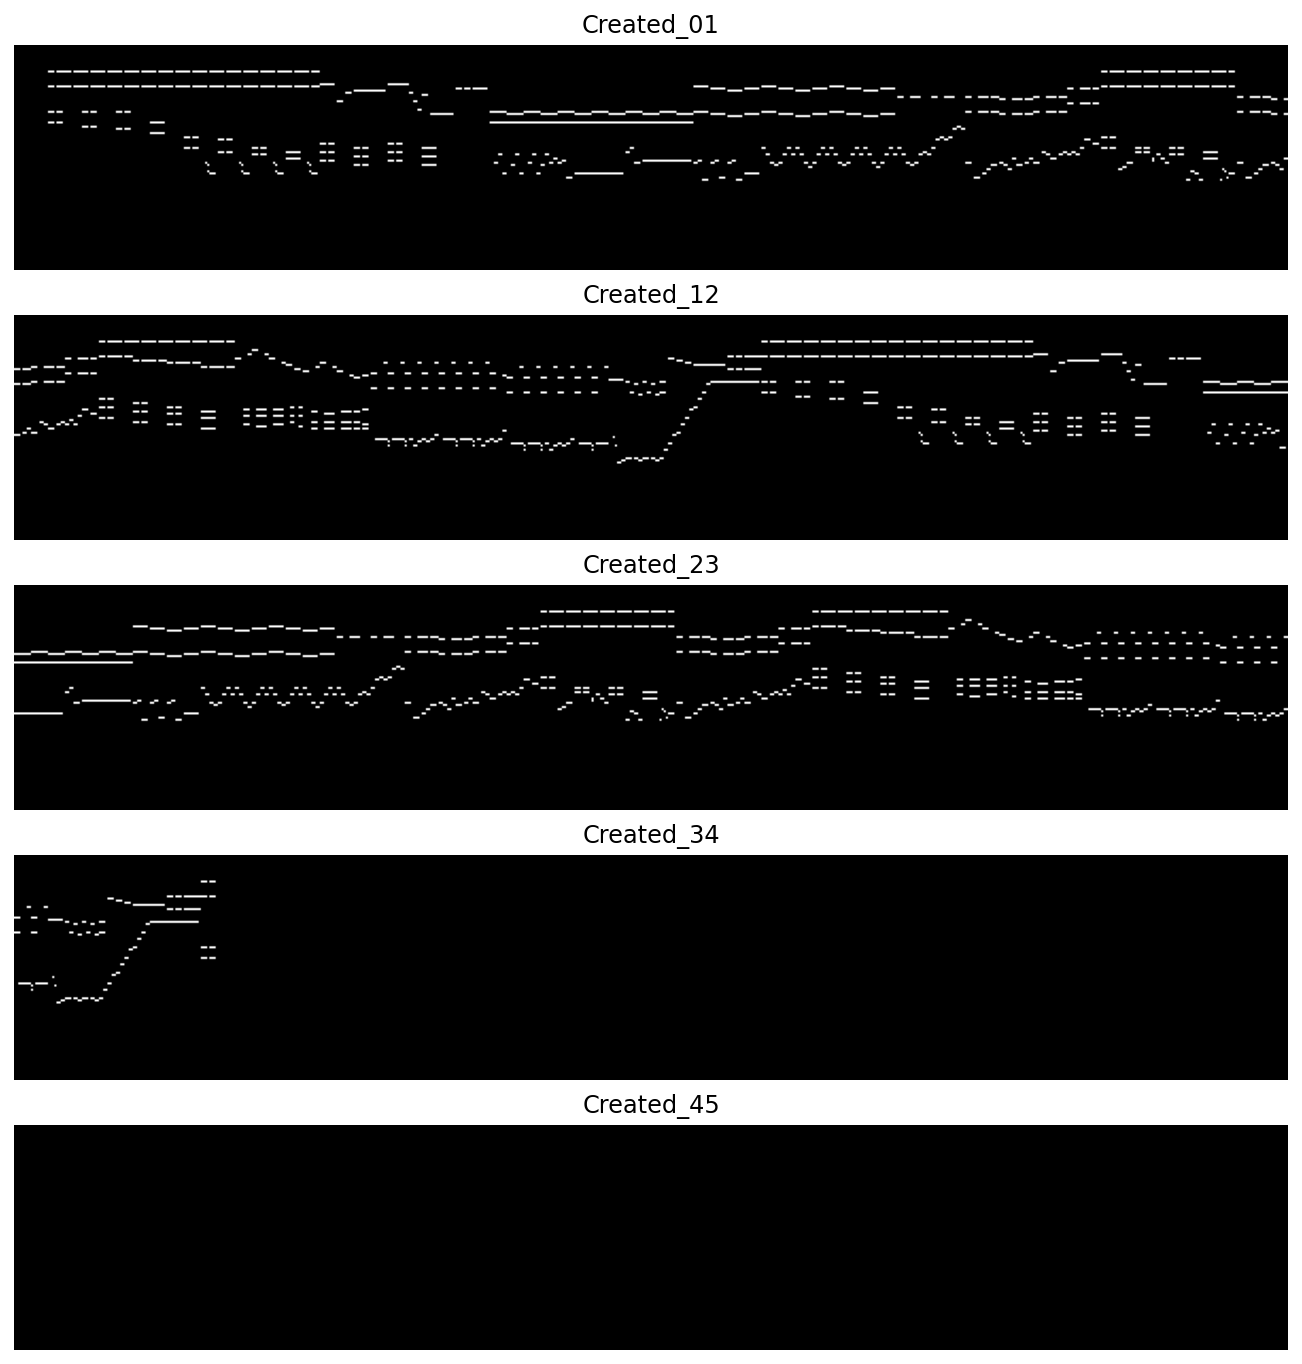

In [7]:
# Plot MIDI images
plt.figure(figsize=(12,12))
for i in range(len(data.keys())):
    data_key = list(data.keys())[i]
    img = data[data_key]
    plt.subplot(len(data.keys()), 1, i+1)
    plt.imshow(img, cmap='gray', vmin=img.min(), vmax=img.max())
    plt.axis('off')
    plt.title(data_key + str(i+1))
plt.show()

In [50]:
# reconvert MIDI images to MIDI files
image_path = "../data/midi_img/piano/0fithos_Created_0.png"
output_path = "../data/midi_reconstruction"

img2midi_obj = img2midi(image_path, output_path, resolution=0.25)
img2midi_obj.convert_to_midi()

In [1]:
# # run to cell to play
# # stop the cell and run sp.stop to stop the music
# mf = midi.MidiFile()
# mf.open(f"{output_path}/music.mid")
# mf.read()
# mf.close()
# s = midi.translate.midiFileToStream(mf)
# sp = midi.realtime.StreamPlayer(s)
# sp.play()

In [2]:
# sp.stop()

## Dataset Construction

In [11]:
# declare output path
output_path = "../data/midi_img"

# instantiate a midi2img converter object
midi2img_obj = midi2img(output_path)

# for each midi file, convert it to image
for midi in tqdm(midis):
    data, metadata = midi2img_obj.convert_to_image(midi)
    for img_key in data.keys():
        try:
            img_path = output_path+"/"+midi.split("/")[-1].replace(".mid",f"_{img_key}.png")
            # print(img_path)
            img = Image.open(img_path)
            basewidth = 106
            hsize = 106
            img = img.resize((basewidth,hsize), Image.ANTIALIAS)
            img.save(img_path)
        except:
            print("Error in converting: "+img_path)
            pass

  0%|          | 0/92 [00:00<?, ?it/s]

C:\Users\ktrin\AppData\Local\Temp\ipykernel_10292\3716288181.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)


Error in converting: ../data/midi_img/piano\0fithos_Created_19.png
Error in converting: ../data/midi_img/piano\8_Piano_4.png
Error in converting: ../data/midi_img/piano\ahead_on_our_way_piano_Piano_15.png
Error in converting: ../data/midi_img/piano\AT_Acoustic Guitar_17.png
Error in converting: ../data/midi_img/piano\balamb_Right Hand_12.png
Error in converting: ../data/midi_img/piano\bcm_Right Hand_10.png
Error in converting: ../data/midi_img/piano\BlueStone_LastDungeon_Right Hand_13.png
Error in converting: ../data/midi_img/piano\braska_Piano_6.png
Error in converting: ../data/midi_img/piano\caitsith_Right Hand_73.png
Error in converting: ../data/midi_img/piano\Cids_Piano_11.png
Error in converting: ../data/midi_img/piano\cosmo_Right Hand_18.png
Error in converting: ../data/midi_img/piano\costadsol_Right Hand_6.png
Error in converting: ../data/midi_img/piano\dayafter_Right Hand_9.png
Error in converting: ../data/midi_img/piano\decisive_Right Hand_8.png
Error in converting: ../data/mi

In [12]:
# Dataset Construction
def access_images(path, num_images=float("inf")):
    """
        Fetch a defined number of images from a directory
        and return their normalized pixels arrays
        Inputs:
            path: path to the directory containing the images
            img_list: list of image names
            num_images: number of images to fetch
        Output:
            image_arr: pixel array of images
            img: the original image
    """
    pixels = []
    imgs = []

    # fetch all images from the directory
    i = 0
    for file in (glob.glob(f"{path}/*.png")):
        if i >= num_images:
            break
        try:
            img = Image.open(file, 'r')
            img = img.convert('1')
            pix = np.array(img.getdata())
            pix = pix.astype('float32')
            pix /= 255.0
            pixels.append(pix.reshape(106,106,1))
            imgs.append(img)
        except:
            pass
        i+=1
    return np.array(pixels), imgs


img_dir = "../data/midi_img/piano"

pixels_arr, imgs = access_images(img_dir)
np.unique(pixels_arr)

array([0., 1.], dtype=float32)

# GAN Definition

GAN model consists of two part:
1. Generator
2. Discriminator

In [2]:
# check to see if tensorflow mount to GPU properly
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def define_generator(latent_dim):
    """Define the generator model
        Inputs:
            latent_dim: dimension of the latent space
        Output:
            model: the generator model
    """
    model = keras.Sequential()
    n_nodes = 128 * 53 * 53
    model.add(keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Reshape((53, 53, 128)))
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))
    return model

In [4]:
def define_discriminator(in_shape = (106,106,1)):
    """
        GAN discriminator model
        Inputs:
            in_shape: shape of the input image
        Output:
            model: discriminator model with binary crossentropy loss to denotes if the image is real or fake
    """
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [5]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = keras.Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
latent_dim = 100
g_model = define_generator(latent_dim)
d_model = define_discriminator()
gan_model = define_gan(g_model, d_model)
g_model.summary(), d_model.summary(), gan_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 359552)            36314752  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 359552)            0         
                                                                 
 reshape (Reshape)           (None, 53, 53, 128)       0         
                                                                 
 dense_1 (Dense)             (None, 53, 53, 1024)      132096    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 106, 106, 1024)   16778240  
 nspose)                                                         
                                                                 
 dense_2 (Dense)             (None, 106, 106, 1024)    1049600   
                                                        

c:\Users\ktrin\miniconda3\envs\W266\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(None, None, None)

In [7]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [8]:
# # generate samples and save as a plot and save the model
# def summarize_performance(step, g_model, gan_model, latent_dim, n_cat, n_samples=100):
# 	# prepare fake examples
# 	X, _ = generate_fake_samples(g_model, latent_dim, n_cat, n_samples)
# 	# scale from [-1,1] to [0,1]
# 	X = (X + 1) / 2.0
# 	# plot images
# 	for i in range(100):
# 		# define subplot
# 		plt.subplot(10, 10, 1 + i)
# 		# turn off axis
# 		plt.axis('off')
# 		# plot raw pixel data
# 		plt.imshow(X[i, :, :, 0], cmap='gray_r')
# 	# save plot to file
# 	filename1 = 'generated_plot_%04d.png' % (step+1)
# 	plt.savefig(filename1)
# 	plt.close()
# 	# save the generator model
# 	filename2 = 'model_%04d.h5' % (step+1)
# 	g_model.save(filename2)
# 	# save the gan model
# 	filename3 = 'gan_model_%04d.h5' % (step+1)
# 	gan_model.save(filename3)
# 	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [9]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=51, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

        if (i+1) % 10 == 0:
            # summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

In [10]:
import joblib
import random

random.seed(5634)

training_set = joblib.load('../data/piano-labelled/training_set.joblib')
training_set = random.sample(training_set, 2048) #5 is the lenth of the sample
pixels_arr, captions = zip(*training_set)
pixels_arr = np.array(pixels_arr)

In [11]:
train(g_model, d_model, gan_model, np.array(pixels_arr), latent_dim, n_epochs=3)

>1, 1/204, d=0.579, g=0.858
>1, 2/204, d=0.167, g=0.964
>1, 3/204, d=0.068, g=0.986
>1, 4/204, d=0.035, g=0.987
>1, 5/204, d=0.073, g=0.936
>1, 6/204, d=0.228, g=0.804
>1, 7/204, d=0.701, g=0.699
>1, 8/204, d=0.878, g=0.681
>1, 9/204, d=0.881, g=0.683
>1, 10/204, d=0.631, g=0.688
>1, 11/204, d=0.601, g=0.689
>1, 12/204, d=0.607, g=0.685
>1, 13/204, d=0.448, g=0.684
>1, 14/204, d=0.462, g=0.687
>1, 15/204, d=0.350, g=0.682
>1, 16/204, d=0.251, g=0.665
>1, 17/204, d=0.401, g=0.674
>1, 18/204, d=0.243, g=0.663
>1, 19/204, d=0.219, g=0.647
>1, 20/204, d=0.235, g=0.635
>1, 21/204, d=0.438, g=0.588
>1, 22/204, d=0.277, g=0.585
>1, 23/204, d=0.176, g=0.597
>1, 24/204, d=0.254, g=0.609
>1, 25/204, d=0.278, g=0.627
>1, 26/204, d=0.255, g=0.594
>1, 27/204, d=0.222, g=0.598
>1, 28/204, d=0.140, g=0.613
>1, 29/204, d=0.146, g=0.618
>1, 30/204, d=0.157, g=0.610
>1, 31/204, d=0.188, g=0.591
>1, 32/204, d=0.103, g=0.586
>1, 33/204, d=0.266, g=0.563
>1, 34/204, d=0.084, g=0.562
>1, 35/204, d=0.214, g=

In [12]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


latent_dim = 100
model = g_model
latent_points = generate_latent_points(latent_dim, 1)
X = g_model.predict(latent_points)
array = np.array(X.reshape(106,106),dtype = np.uint8)
array*= 255
new_image = Image.fromarray(array,'L')
new_image = new_image.save('../data/midi_reconstruction/images/composition.png')

In [13]:
# reconvert MIDI images to MIDI files
image_path = "../data/midi_reconstruction/images/composition.png"
output_path = "../data/midi_reconstruction"

img2midi_obj = img2midi(image_path, output_path, resolution=0.25)
img2midi_obj.convert_to_midi()

In [14]:
# save the model
g_model.save('../models/mini-gan/piano_generator_model.h5')
d_model.save('../models/mini-gan/piano_discriminator_model.h5')
gan_model.save('../models/mini-gan/piano_gan_model.h5')

In [15]:
# run to cell to play
# stop the cell and run sp.stop to stop the music
from music21 import midi, converter, instrument, note, chord

mf = midi.MidiFile()
mf.open(f"{output_path}/music.mid")
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
sp = midi.realtime.StreamPlayer(s)
sp.play()

pygame 2.5.1 (SDL 2.28.2, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [16]:
sp.stop

<bound method StreamPlayer.stop of <music21.midi.realtime.StreamPlayer object at 0x0000018D8FCEAF10>>